In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from scipy.stats import poisson, norm, invgamma, uniform

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
GAMMA = 2
ZETA = 3
RHO = 3
NU  = 4

np.random.seed(111)
ALPHA  = norm.rvs(size=J, loc=MU, scale=TAU)
BETA   = norm.rvs(size=J, loc=GAMMA, scale=ZETA)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

VARIABLE = 'Y'
PREDICTOR = 'X'

ALPHA_LEVEL = 0.05

Create the data

In [3]:
np.random.seed(111)
X = uniform.rvs(size=N[0])
Y = norm.rvs(size=N[0], loc=ALPHA[0] + BETA[0] * (X-np.mean(X)), scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, X, [0]*N[0]]).T)

for j in range(1,J):
    X = uniform.rvs(size=N[j])
    Y = norm.rvs(size=N[j], loc=ALPHA[j] + BETA[j] * (X-np.mean(X)), scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, X, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:PREDICTOR, 2:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

In [4]:
Dat = Dat[[VARIABLE, PREDICTOR, 'Region']]

In [5]:
PredictorMean = Dat[PREDICTOR].mean()

---

Calculate the statistics per region

In [6]:
DatRegion = Dat[[PREDICTOR, VARIABLE, 'Region']].groupby(['Region']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion[[PREDICTOR + 'Region', 'Region']], on='Region')

In [7]:
DatRegion = Dat[[VARIABLE, 'Region']].groupby(['Region']).agg(['mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '': 'Region'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'
    }
)

---

Estimate $\nu$ for all the data

In [8]:
ES2 = (DatRegion[VARIABLE + 'Std']**2).mean()
VS2 = (DatRegion[VARIABLE + 'Std']**2).var()

HatNu = 2 * ES2**2 / VS2 + 4

---

Regression model with common $\alpha$ and $\beta$

In [9]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE])

Regression model with separate $\alpha$'s and $\beta$'s

In [10]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['Region']] + Beta[Dat['Region']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

---

In [11]:
TraceCommonAlphaCommonBeta = pm.sample(model = ModelCommonAlphaCommonBeta)
TraceSeparateAlphaSeparateBeta = pm.sample(model = ModelSeparateAlphaSeparateBeta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [12]:
HatMeanMu = TraceCommonAlphaCommonBeta.posterior.Alpha.values.mean()
HatStdMu  = TraceCommonAlphaCommonBeta.posterior.Alpha.values.std()

HatMeanBeta = TraceCommonAlphaCommonBeta.posterior.Beta.values.mean()
HatStdBeta  = TraceCommonAlphaCommonBeta.posterior.Beta.values.std()

HatMeanTau = float(TraceSeparateAlphaSeparateBeta.posterior.Alpha.mean(('chain', 'draw')).std().values)

---

In [13]:
with pm.Model() as ModelVaryingAlphaCommonBeta:

    Tau   = pm.Exponential('Tau', lam=1/HatMeanTau)
    Mu    = pm.Normal('Mu', mu=HatMeanMu, sigma=HatStdMu) # National average income
    Alpha = pm.Normal('Alpha', mu=Mu, sigma=Tau, shape=J) # Regional average income

    Beta = pm.Normal('Beta', mu=HatMeanBeta, sigma=HatStdBeta)

    Rho = pm.HalfFlat('Rho')
    pm.Potential('p(Rho)', -pm.math.log(Rho))

    Nu = pm.Exponential('Nu', lam=1/HatNu)

    Sigma2 = pm.InverseGamma('Sigma2', alpha=Nu/2, beta=Nu/2 * Rho**2, shape=J)
    Sigma  = pm.Deterministic('Sigma', pm.math.sqrt(Sigma2))

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['Region']] + Beta * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal(
        'Income'
        , mu = MeanIncome
        , sigma = Sigma[Dat['Region']]
        , observed = Dat[VARIABLE]
    )

Get a sample from the posterior and the posterior predictive

In [14]:
with ModelVaryingAlphaCommonBeta:
    TraceVaryingAlphaCommonBeta = pm.sample()
    TraceVaryingAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceVaryingAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tau, Mu, Alpha, Beta, Rho, Nu, Sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Income]


---

Regional average income, ratio of income per year-of-education

In [15]:
PosteriorAlpha = az.summary(
    TraceVaryingAlphaCommonBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Alpha'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100)  + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%': 'UppAlpha'
    }
)

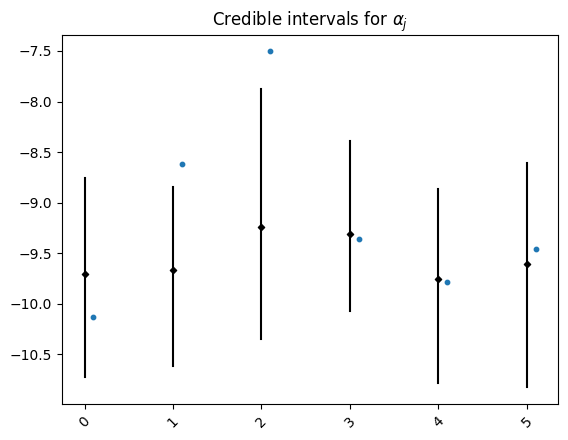

In [16]:
plt.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), ALPHA, marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
        color='k'
    )

plt.title(r'Credible intervals for $\alpha_j$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

Text(0.5, 1.0, 'Posterior distribution of $\\beta$')

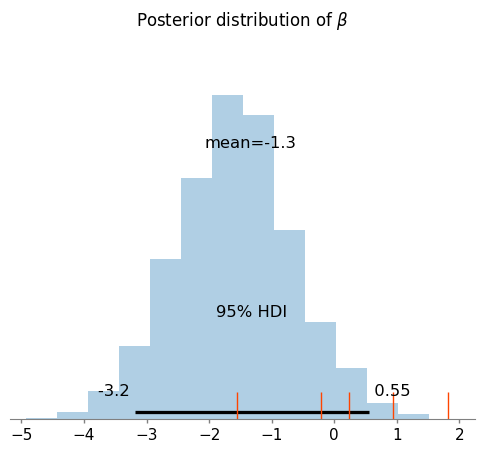

In [17]:
_, axes = plt.subplots(1,1, figsize=(6,5))

az.plot_posterior(
    TraceVaryingAlphaCommonBeta
    , var_names = 'Beta'
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
    , ax = axes
)

sns.rugplot(BETA, ax=axes, color='orangered', height=0.07)

axes.set_title(r"Posterior distribution of $\beta$")

Scatterplot

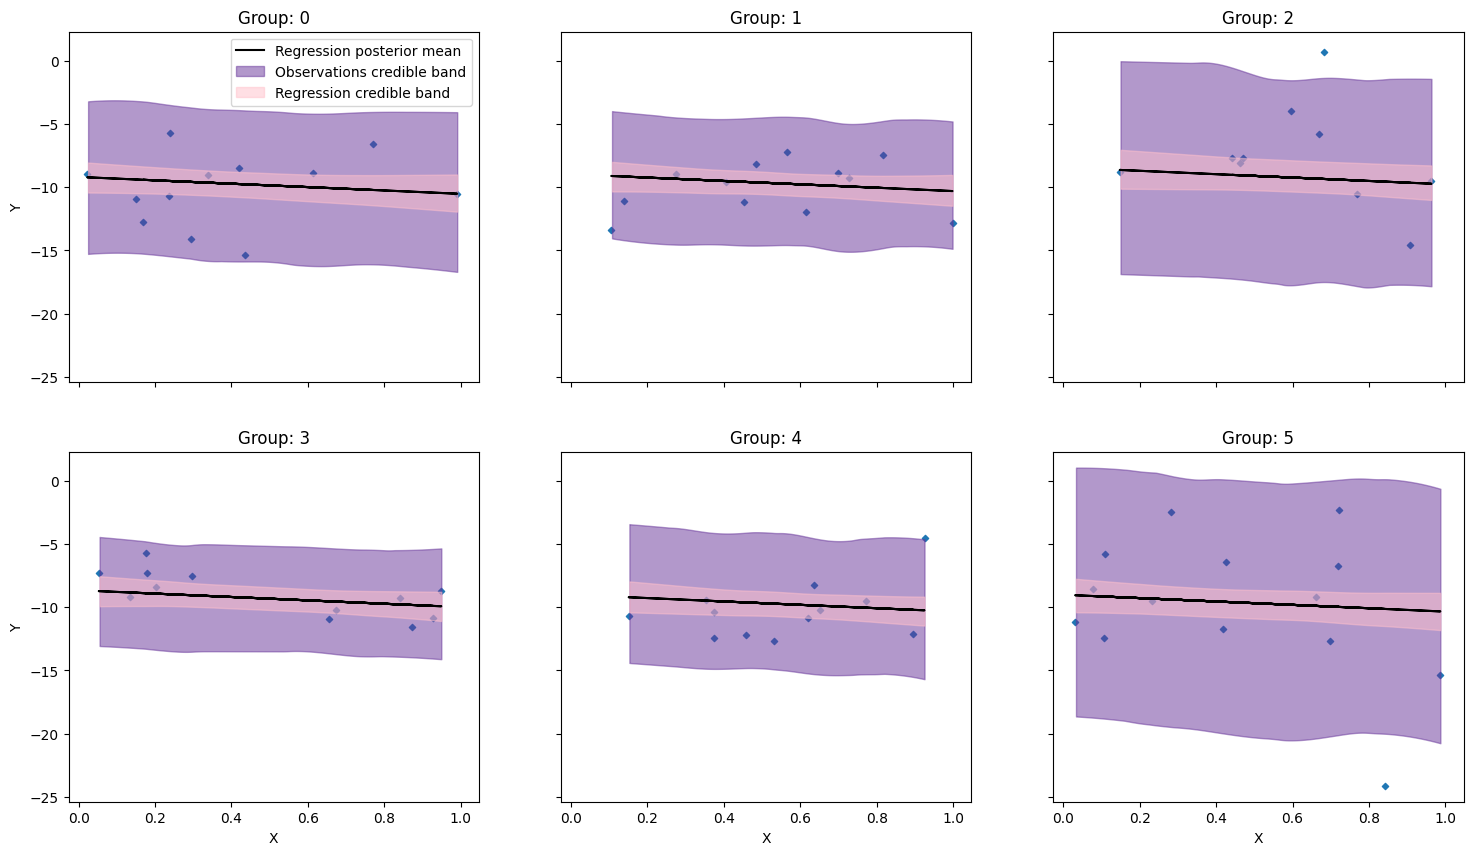

In [18]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['Region']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE]
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceVaryingAlphaCommonBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Regression posterior mean"
        , color='k'
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaCommonBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceVaryingAlphaCommonBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
        , ax = ax
    )

    ax.set_title('Group: ' + str(k))

    if k in [0,3]:
        ax.set_ylabel(VARIABLE)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR)